In [1]:
#  Ebnable HTML/CSS 
from IPython.core.display import HTML
HTML("<link href='https://fonts.googleapis.com/css?family=Passion+One' rel='stylesheet' type='text/css'><style>div.attn { font-family: 'Helvetica Neue'; font-size: 30px; line-height: 40px; color: #FFFFFF; text-align: center; margin: 30px 0; border-width: 10px 0; border-style: solid; border-color: #5AAAAA; padding: 30px 0; background-color: #DDDDFF; }hr { border: 0; background-color: #ffffff; border-top: 1px solid black; }hr.major { border-top: 10px solid #5AAA5A; }hr.minor { border: none; background-color: #ffffff; border-top: 5px dotted #CC3333; }div.bubble { width: 65%; padding: 20px; background: #DDDDDD; border-radius: 15px; margin: 0 auto; font-style: italic; color: #f00; }em { color: #AAA; }div.c1{visibility:hidden;margin:0;height:0;}div.note{color:red;}</style>")

Enter Team Member Names here (*double click to edit*):

- Name 1:Ethan Chou
___

# In Class Assignment Two
In the following assignment you will be asked to fill in python code and derivations for a number of different problems. Please read all instructions carefully and turn in the rendered notebook (or HTML of the rendered notebook)  before the end of class (or right after class). The initial portion of this notebook is given before class and the remainder is given during class. Please answer the initial questions before class, to the best of your ability. Once class has started you may rework your answers as a team for the initial part of the assignment. 

<a id="top"></a>
## Contents
* <a href="#Loading">Loading the Data</a>
* <a href="#ff">Defining a Feedforward Network in Python</a>
* <a href="#bp">Back Propagation in Python</a>
* <a href="#vis">Visualizing Back Propagation</a>
________________________________________________________________________________________________________

<a id="Loading"></a>
<a href="#top">Back to Top</a>
## Loading the Data
Please run the following code to read in the "digits" dataset from sklearn's data loading module. This data contains hand written digits for the characters 0-9.

This will load the data into the variable `ds`. `ds` is a `bunch` object with fields like `ds.data` and `ds.target`. The field `ds.data` is a numpy matrix of the continuous features in the dataset. **The object is not a pandas dataframe. It is a numpy matrix.** Each row is a set of observed instances, each column is a different feature. It also has a field called `ds.target` that is an integer value we are trying to predict (i.e., a specific integer represents a specific person). Each entry in `ds.target` is a label for each row of the `ds.data` matrix. 

In [6]:
# lets load up the handwritten digit dataset
from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import numpy as np

ds = load_digits()
X = ds.data/16.0-0.5 # normalize the data
y = ds.target

print(X.shape)
print(y.shape)
print(np.min(X),np.max(X))
print(np.unique(y))

(1797, 64)
(1797,)
-0.5 0.5
[0 1 2 3 4 5 6 7 8 9]


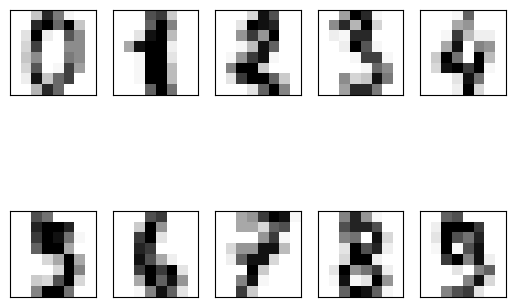

In [7]:
# reshape and print a few of the images in the digits dataset
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(10):
    img = X[i].reshape(8, 8)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.show()


____
**Question 1:** For the digits dataset, what does each column in $\mathbf{X}$ represent? What does each row in $\mathbf{X}$ represent? What does each value in $\mathbf{X}$ represent? What does each unique value of the target, $y$ represent?

Enter you answer here (*double click to edit*)

- Column: Each column in X represents a feature.
- Row: Each row in X represents a single sample, which is an image of a digit
- Value: Each value in X represents the specific pixel in a specific image
- Unique Target in $y$: Each unique value of the target, $y$, represents a digit class that the corresponding image in X belongs to.

___

____

<img src="https://raw.githubusercontent.com/eclarson/MachineLearningNotebooks/master/PDF_Slides/MultiLayerNetwork.png" width="500">

**Question 2:** For the digits dataset, we want to train a neural network with one hidden layer (two layers total). The hidden layer will have 30 neurons. What will be the size of the matrices and bias terms in each layer? That is, what is the size of $\mathbf{W}^{(1)}$, $\mathbf{b}^{(1)}$, and what is the size of $\mathbf{W}^{(2)}$, $\mathbf{b}^{(2)}$? 



Enter you answer here (*double click to edit*)

- $\mathbf{W}^{(1)}$: 64 X 30
- $\mathbf{b}^{(1)}$: 30 X 1
- $\mathbf{W}^{(2)}$: 10 X 30
- $\mathbf{b}^{(2)}$: 10 X 1


___

<a id="ff"></a>
<a href="#top">Back to Top</a>



# Defining a Feedforward Network

Below we will setup the functions for use in a feedforward neural network **with two layers**. Take a quick look at the functions defined. There are a number of convenience functions including:
- a function for the sigmoid calculation
- a function to one hot encode the output
- an initialization function for initializing the weights

A few functions are not yet implemented including:
- a `fit` function
- a `get_gradient` function

In [8]:
# Example adapted from https://github.com/rasbt/python-machine-learning-book/blob/master/code/ch12/ch12.ipynb
# Original Author: Sebastian Raschka

# This is the optional book we use in the course, excellent intuitions and straightforward programming examples
# please note, however, that this code has been manipulated to reflect our assumptions and notation.
import numpy as np
from scipy.special import expit
import sys
import pandas as pd

# start with a simple base classifier, which can't be fit or predicted
# it only has internal classes to be used by classes that will subclass it
class TwoLayerPerceptronBase(object):
    def __init__(self, n_hidden=30,
                 C=0.0, epochs=500, eta=0.001, random_state=None):
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        
    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
            
        return onehot
    
    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)
    
    
    @staticmethod
    def _L2_reg(lambda_, W1, W2):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_) * np.sqrt(np.mean(W1 ** 2) + np.mean(W2 ** 2))
    
    
    def _cost(self,A3,Y_enc,W1,W2):
        '''Get the objective function value'''
        cost = np.mean((Y_enc-A3)**2)
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        return cost + L2_term
    
    
    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        W1_num_elems = (self.n_features_)*self.n_hidden
        W1 = np.random.uniform(-1.0, 1.0, size=W1_num_elems)
        W1 = W1.reshape(self.n_hidden, self.n_features_) # reshape to be W
        b1 = np.zeros((self.n_hidden, 1))
        
        W2_num_elems = (self.n_hidden)*self.n_output_
        W2 = np.random.uniform(-1.0, 1.0, size=W2_num_elems)
        W2 = W2.reshape(self.n_output_, self.n_hidden)
        b2 = np.zeros((self.n_output_, 1))
        
        return W1, W2, b1, b2
    
    
    def _feedforward(self, X, W1, W2, b1, b2):
        """Compute feedforward step
        -----------
        X : Input layer with original features.
        W1: Weight matrix for input layer -> hidden layer.
        W2: Weight matrix for hidden layer -> output layer.
        ----------
        a1-a3 : activations into layer (or output layer)
        z1-z2 : layer inputs 

        """
        A1 = X.T
        Z1 = W1 @ A1 + b1
        A2 = self._sigmoid(Z1)
        Z2 = W2 @ A2 + b2
        A3 = self._sigmoid(Z2)
        return A1, Z1, A2, Z2, A3
    
    def predict(self, X):
        """Predict class labels"""
        _, _, _, _, A3 = self._feedforward(X, self.W1, self.W2, self.b1, self.b2)
        y_pred = np.argmax(A3, axis=0)
        return y_pred
    
    
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # will write this function below
        pass
    
    def fit(self, X, y, print_progress=False):
        """ Learn weights from training data.
            Input X should be a matrix with separate instances
            in each row, and separate features in each column.
            The target variable, y, should be integer values 
            starting from zero, that represent the unique classes.
        """
        # will write this function below
        pass
    


___
<img src="https://raw.githubusercontent.com/eclarson/MachineLearningNotebooks/master/PDF_Slides/MultiLayerNetwork.png" width="500">

Recall from the videos that all instances in $\mathbf{X}$ can be fed into the network with a single matrix multiplication operation for each intermediate vector, $\mathbf{a}^{(l)}$ and $\mathbf{z}^{(l)}$. When we feed all the instances, $\mathbf{X}$, the intermediate vectors, $\mathbf{a}^{(l)}$ and $\mathbf{z}^{(l)}$ get stacked together to form matrices, $\mathbf{A}^{(l)}$ and $\mathbf{Z}^{(l)}$. This is already done for you in the `_feedforward` function defined above.

**Question 3:**
For the digits dataset we are using and a network with 30 neurons in the hidden layer, what are the sizes of:
- **Part A**: the intermediate vectors, $\mathbf{a}^{(1)}$ and $\mathbf{a}^{(2)}$
- **Part B**: the intermediate vectors, $\mathbf{z}^{(1)}$ and $\mathbf{z}^{(2)}$
- **Part C**: the intermediate matrices, $\mathbf{A}^{(1)}$ and $\mathbf{A}^{(2)}$
- **Part D**: the intermediate matrices, $\mathbf{Z}^{(1)}$ and $\mathbf{Z}^{(2)}$



*Enter you answer here (double click)*


A.  $a^{(1)}$ has a size of 64 X 1 and $a^{(2)}$ has a size of 30 X 1 


B.  $z^{(1)}$ has a size of 30 X 1, and $z^{(2)}$ has a size of 10 X 1, 


C.  $\mathbf{A}^{(1)}$ has a size of 64 X 1797, and $\mathbf{A}^{(2)}$ has a size of 30 X 1797


D.  $\mathbf{Z}^{(1)}$ has a size of 30 X 1797, and $\mathbf{Z}^{(2)}$ has a size of 10 X 1797
___

___
<a id="bp"></a>
<a href="#top">Back to Top</a>

# Back Propagation in Python
Now let's add in the back propagation steps from the video. First, we need to add in a `fit` function that will update all the trainable weights in the $\mathbf{W}^{(l)}$ matrices. Because this is a two layer network we have layers $\mathbf{W}^{(1)}$ and $\mathbf{W}^{(2)}$. Look at the given `fit` function written below for you. 

The `fit` function below will update matrices using steepest descent. And the update equation is:
$$  w_{i,j}^{(l)} \leftarrow w_{i,j}^{(l)} - \eta \frac{\partial J(\mathbf{W})}{\partial w_{i,j}^{(l)}}$$

for each value in each matrix, $\mathbf{W}^{(l)}$. 

The objective function is simply the mean squared error:
$$ J(\mathbf{W}) = \sum_{k=1}^M (\mathbf{y}^{(k)}-[\mathbf{a}^{(L)}]^{(k)})^2 $$

where $L$ is the output of the last layer. For our two layer implementation, $L=3$.

In [9]:
class TwoLayerPerceptron(TwoLayerPerceptronBase):
    def fit(self, X, y, print_progress=False):
        """ Learn weights from training data.
            Input X should be a matrix with separate instances
            in each row, and separate features in each column.
            The target variable, y, should be integer values 
            starting from zero, that represent the unique classes.
        """
        
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2, self.b1, self.b2 = self._initialize_weights()
        
        #------------------------------------------
        # You will update These arrays, initialized here 
        self.grad_w1_ = np.zeros(self.epochs)
        self.grad_w2_ = np.zeros(self.epochs)
        
        #------------------------------------------

        self.cost_ = []
        for i in range(self.epochs):

            # feedforward all instances
            A1, Z1, A2, Z2, A3 = self._feedforward(X_data,self.W1,self.W2, self.b1, self.b2)
            
            cost = self._cost(A3,Y_enc,self.W1,self.W2)
            self.cost_.append(cost)

            # compute gradient via backpropagation
            # WE HAVE NOT YET WRITTEN THE GRADIENT FUNCTION YET
            gradW1, gradW2, gradb1, gradb2 = self._get_gradient(A1=A1, 
                                                                A2=A2, 
                                                                A3=A3, 
                                                                Z1=Z1, 
                                                                Z2=Z2, 
                                                                Y_enc=Y_enc,
                                              W1=self.W1, W2=self.W2)
            
            #------------------------------------------
            # ENTER YOUR CODE HERE to keep track of the 
            # magnitude of gradients grad_w1_ and grad_w2_
            
            # Track the magnitude of the gradient 
            self.grad_w1_[i] = np.linalg.norm(gradW1) / np.size(gradW1)
            self.grad_w2_[i] = np.linalg.norm(gradW2) / np.size(gradW2)
            
            #------------------------------------------

            self.W1 -= self.eta * gradW1
            self.W2 -= self.eta * gradW2
            self.b1 -= self.eta * gradb1
            self.b2 -= self.eta * gradb2
            

        return self
    
    

**Exercise 1:** In the code above, add class properties (variables), `grad_w1_` and `grad_w2_` that save the average magnitude of the gradient for each layer at every epoch. That is, if you ran the `fit` function for 50 epochs, `grad_w1_` and `grad_w2_` would be 50 element vectors when training is complete.

When training is completed, `grad_w1_` and `grad_w2_` should be accessible using dot notation from the class object, as shown in the example syntax below. 

```
clf = TwoLayerPerceptron()
clf.fit(X,y)
clf.grad_w1_ 
clf.grad_w2_
```
___

## Adding the Gradient Calculation
From the videos, recall that the the sensitivities, $\mathbf{V}$, can be calculated as follows:

$$ \mathbf{V}^{(2)} = -2(\mathbf{Y}-\mathbf{A}^{(3)})*\mathbf{A}^{(3)}*(1-\mathbf{A}^{(3)}) $$
$$ \mathbf{V}^{(1)} =  \mathbf{A}^{(2)} * (1-\mathbf{A}^{(2)}) * [\mathbf{W}^{(2)}]^T \cdot \mathbf{V}^{(2)}  $$

Once we have these sensitivities, its easy to calculate the gradient of each layer. The gradient of the objective function with respect to the final layer $\mathbf{W}^{(2)}$ can be calculated with:
$$  \frac{\nabla J(\mathbf{W})}{\partial\mathbf{W}^{(2)}} = \mathbf{V}^{(2)}\cdot [\mathbf{A}^{(2)}]^T $$

And the gradient of the objective function with respect to the first layer $\mathbf{W}^{(2)}$ can be calculated with: 
$$  \frac{\nabla J(\mathbf{W})}{\partial\mathbf{W}^{(1)}} = \mathbf{V}^{(1)}\cdot [\mathbf{A}^{(1)}]^T $$

___
** Exercise 2:** In the code below, use numpy linear algebra functions to calculate the sensitivities at each layer, $\mathbf{V}^{(1)}$ and $\mathbf{V}^{(2)}$. This will complete the `_get_gradient` private method.

In [10]:
class TwoLayerPerceptronVect(TwoLayerPerceptron):
    # just need a different gradient calculation
    
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        
        #---------------------------------
        # ENTER YOUR CODE HERE to
        # calculate the sensitivities
        # NOTE: be sure to use parentheses for correct order of operations...
        V2 = -2 * (Y_enc - A3) * A3 * (1 - A3)
        V1 = (W2.T @ V2) * A2 * (1 - A2)
        #---------------------------------
        
        # Use of sensitivity is calculated for you here
        gradW2 = V2 @ A2.T
        gradW1 = V1 @ A1.T
        
        gradb2 = np.sum(V2, axis=1).reshape((-1,1))
        gradb1 = np.sum(V1, axis=1).reshape((-1,1))
        
        
        # regularize weights that are not bias terms
        gradW1 += W1 * self.l2_C * 2
        gradW2 += W2 * self.l2_C * 2 

        return gradW1, gradW2, gradb1, gradb2
    


___
<a id="vis"></a>
<a href="#top">Back to Top</a>

# Visualizing Back Propagation
Now let's test the code you wrote above to perform gradient calculations and save the magnitude of the gradient at each epoch. Run the code in the cell below. If it runs and the accuracy is relatively high, it is likely that your sensitivity calculation above was written correctly.

*If it does not run or the accuracy is low, there is probably something wrong with the sensitivity calculation. Try to fix it before moving on.*

In [11]:
clf = TwoLayerPerceptronVect(n_hidden=10, epochs=1500, eta=0.001)
clf.fit(X,y)

from sklearn.metrics import accuracy_score
yhat = clf.predict(X)
accuracy_score(y,yhat)

0.9766277128547579

___
## Visualizing the gradients
Now let's check your calculation of the average gradient magnitude. Run the code below to visualize the average gradient magnitude versus the epochs run while training. 

*If the code below does not run, you likely have an error in your calculation of the average gradient magnitude.*

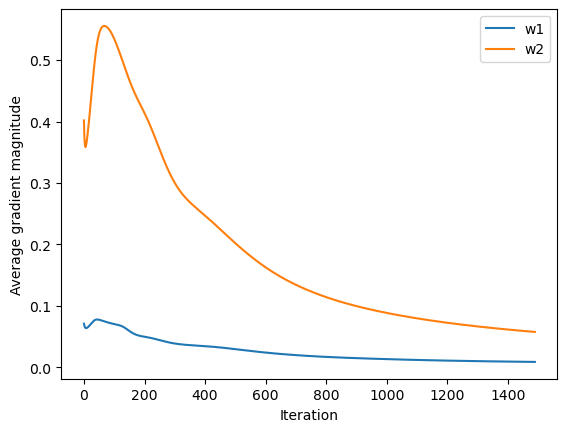

In [12]:
ax = plt.subplot(1,1,1)
plt.plot(np.abs(clf.grad_w1_[10:]), label='w1')
plt.plot(np.abs(clf.grad_w2_[10:]), label='w2')
plt.legend()
plt.ylabel('Average gradient magnitude')
plt.xlabel('Iteration')
plt.show()

**Question 5:** In the plot above, you should see that one layer always has a larger gradient magnitude than the other layer. 

- **Part A:** Which layer always has the larger magnitude? Why do you think this particular layer always has a larger magnitude? 
- **Part B:** If one layer has a larger gradient, does this also mean that the weights for that layer are training more quickly (that is, with fewer iterations)? Is that desireable for training the neural network? Explain your reasoning. 

*Enter you answer here (double click to edit)*

- Part A: The layer with the larger magnitude is the w2 layer. The layer has a larger magnitude because of the derivative of the sigmoid, which is always less than 1. The first layer gradiesnt is calculated from the last layer gradient and the multiplier to get the first layer gradient. This means that the gradient will get smaller and smaller for successively earlier layers


- Part B: A larger gradient does not necessarily mean that the weights for that layer are training more quickly. The update magnitude also depends on the learning rate and the regularization term applied during training. If the learning rate is too high, it may cause the weights to change too drastically, leading to unstable learning. Conversely, if it is too low, it might slow down the learning process. It is desirable to have balanced learning across layers to ensure that all parts of the network are learning at a good pace. If one layer learns much faster than others, it may dominate the learning process and cause other layers to not learn effectively.When training a neural network, it is important to have a balanced update across all layers.

___

**Final Exercise:** In the block of code below, come up with an adaptive scheme to mitigate the effect of unequal magnitude gradients in each layer. Your algorithm should not 'break' the optimization algorithm (*i.e.*, the accuracy should remain somewhat high). Save the magnitude of the resulting update for each layer. 

Explain your scheme below (that is, document what your adaptive algorithm does) and then implement your strategy below. 

___
Enter description here (*double click to edit*)

To mitigate the effect of unequal gradient magnitudes in each layer, an adaptive learning rate for each layer could be used. This approach adjusts the learning rate based on the magnitude of the gradients for each layer independently. The idea is to scale down the learning rate for the layer with the larger gradient to prevent large updates and scale up the learning rate for the layer with the smaller gradient to encourage more significant updates.

For preventing unequal gradients, we decided to ...

If one layer's gradient magnitude is significantly larger than the other's, reduce its learning rate by multiplying it by a factor less than 1. Conversely, increase the learning rate for the layer with the smaller gradient magnitude by multiplying it by a factor greater than 1



___

0.9821925431274346


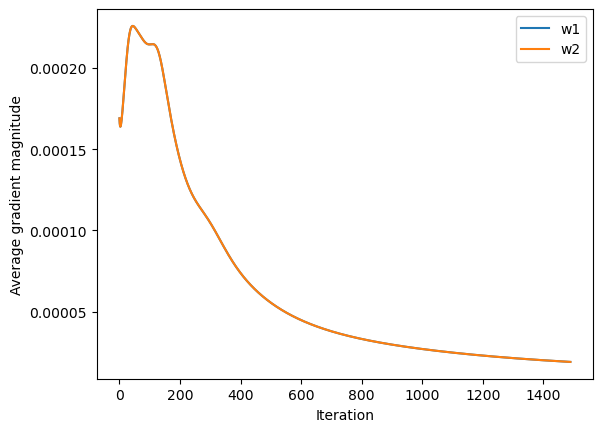

In [14]:
class TwoLayerPerceptronNew(TwoLayerPerceptronVect):
    def fit(self, X, y, print_progress=False):
        """ Learn weights from training data.
            Input X should be a matrix with separate instances
            in each row, and separate features in each column.
            The target variable, y, should be integer values 
            starting from zero, that represent the unique classes.
        """
        
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2, self.b1, self.b2 = self._initialize_weights()
        
        #------------------------------------------
        # You will update These arrays, initialized here 
        self.grad_w1_ = np.zeros(self.epochs)
        self.grad_w2_ = np.zeros(self.epochs)
        self.update_w1_ = np.zeros(self.epochs)
        self.update_w2_ = np.zeros(self.epochs)
        
        #------------------------------------------

        self.cost_ = []
        for i in range(self.epochs):

            # feedforward all instances
            A1, Z1, A2, Z2, A3 = self._feedforward(X_data,self.W1,self.W2, self.b1, self.b2)
            
            cost = self._cost(A3,Y_enc,self.W1,self.W2)
            self.cost_.append(cost)

            # compute gradient via backpropagation
            gradW1, gradW2, gradb1, gradb2 = self._get_gradient(A1=A1, 
                                                                A2=A2, 
                                                                A3=A3, 
                                                                Z1=Z1, 
                                                                Z2=Z2, 
                                                                Y_enc=Y_enc,
                                              W1=self.W1, W2=self.W2)
            
            #------------------------------------------
            # ENTER YOUR CODE HERE to keep track of the 
            #    average magnitude of gradient of each layer 
            #    grad_w1_ and grad_w2_
            #    and make the eta values for each adaptive 
            
            
            # Track the magnitude of the gradient 
            #self.grad_w1_[i] = ??? #(use same calculation as above)
            #self.grad_w2_[i] = ??? #(use same calculation as above)
            
            self.grad_w1_[i] = np.linalg.norm(gradW1) / np.size(gradW1)
            self.grad_w2_[i] = np.linalg.norm(gradW2) / np.size(gradW2)
            # Implement an adaptive learning rate scheme
            # The ratio of the gradients' magnitudes is used to adjust the learning rates
            ratio = self.grad_w1_[i] / (self.grad_w2_[i] + 1e-8)  # Add epsilon to avoid division by zero

            # Adjust eta for each layer based on the ratio
            eta1 = self.eta * (1 / np.sqrt(ratio))
            eta2 = self.eta * np.sqrt(ratio)            
            #------------------------------------------

            self.W1 -= self.eta * gradW1
            self.W2 -= self.eta * gradW2
            self.b1 -= self.eta * gradb1
            self.b2 -= self.eta * gradb2
            
            #------------------------------------------
            # ENTER YOUR CODE HERE
            # Track the magnitude of the gradient update here
            # This should be AFTER applying your dynamic scaling
            # That is, you SHOULD include eta here.
            
            self.update_w1_[i] = eta1 * np.linalg.norm(gradW1) / np.size(gradW1)
            self.update_w2_[i] = eta2 * np.linalg.norm(gradW2) / np.size(gradW2)
            
            #------------------------------------------
            

        return self
    
    
    
clf2 = TwoLayerPerceptronNew(n_hidden=10, epochs=1500, eta=0.001)
clf2.fit(X,y)

from sklearn.metrics import accuracy_score
yhat = clf2.predict(X)
# the accuracy of the classifier should remain high!
# Do not let your dynamic updates make the classifier worse...
print(accuracy_score(y,yhat))

ax = plt.subplot(1,1,1)
plt.plot(np.abs(clf2.update_w1_[10:]), label='w1')
plt.plot(np.abs(clf2.update_w2_[10:]), label='w2')
plt.legend()
plt.ylabel('Average gradient magnitude')
plt.xlabel('Iteration')
plt.show()

________________________________________________________________________________________________________

That's all! Please **save (make sure you saved!!!) and upload your rendered notebook** and please include **team member names** in the notebook submission.